In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
image = 'bilateral.jpg'

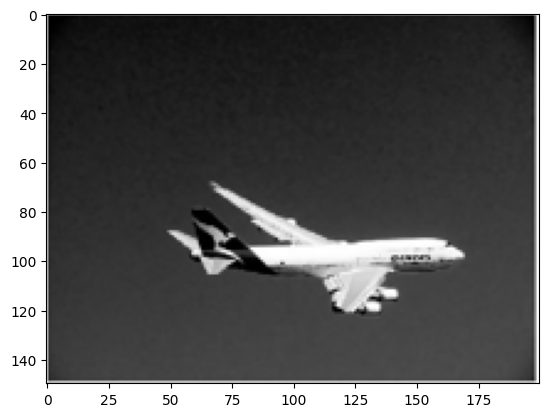

In [4]:
img = Image.open(image)
img = img.resize((200, 150))
img = np.asarray(img)

plt.imshow(img)
plt.show()

In [5]:
img.shape

(150, 200, 3)

In [6]:
def img_mean(img):
    g_img = []
    for x in img:
        arr = []
        for  y in x:
            new_pixel = y.mean()
            arr.append(new_pixel)
        g_img.append(arr)

    return np.array(g_img)


grey_img = img_mean(img)
cols = grey_img.shape[1]
grey_img.shape

(150, 200)

In [7]:
def show_image(image):
    g_imgplot = plt.imshow(image)
    plt.show()

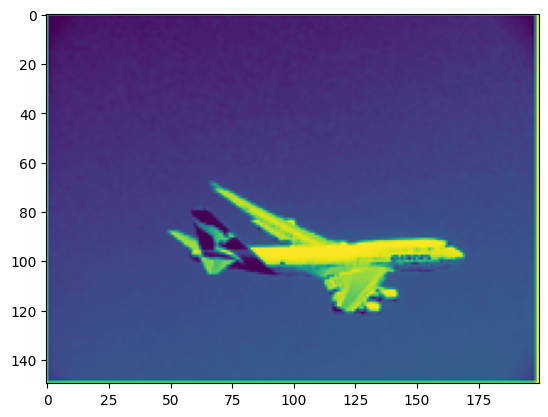

In [8]:
show_image(grey_img)

In [9]:
grey_img.shape

(150, 200)

In [10]:
from scipy.sparse import csr_matrix

def img_to_csgraph(img, positive=True, threshold=0):
    mul = 1
    if not positive:
        mul = -1

    threshold=threshold*mul

    rows, cols = img.shape

    arr = np.reshape(img, (-1))
    n = len(arr)

    csgraph = []

    for idx, pixel in enumerate(arr):
        distance_array = np.zeros(n)

        x = idx%cols
        y = int(idx/cols)


        if not x == cols - 1:
            value = abs(pixel-arr[idx+1])*mul  
            value = value + mul
            distance_array[idx+1] = value if value > threshold else 0

        if not y == rows - 1:
            value = abs(pixel-arr[idx+cols])*mul
            value = value + mul
            distance_array[idx+cols] = value if value > threshold else 0

        csgraph.append(distance_array)


    csgraph = np.array(csgraph)
    return csr_matrix(csgraph)


In [11]:
img_csgraph_min= img_to_csgraph(grey_img, True, 10)

In [12]:
img_csgraph_max = img_to_csgraph(grey_img, False, 10)

In [13]:
from scipy.sparse.csgraph import minimum_spanning_tree

In [14]:
minimum_graph = minimum_spanning_tree(img_csgraph_min)
maximum_graph = minimum_spanning_tree(img_csgraph_max)

In [15]:
def plot_csr(graph, dual_graph=False, remove_original=False):
    plt.figure(figsize=(40, 40))

    for idx, x in enumerate(graph.toarray()):

        non_zero = np.where(x!=0)[0]
        if len(non_zero) == 0:
            continue

        for ind in non_zero:
            x1, y1 = idx%cols, int(idx/cols)
            x2, y2 = ind%cols, int(ind/cols)

            if not remove_original:
                plt.plot([x1, x2], [y1, y2], linewidth=0.8, color='blue', marker='.', markerfacecolor='red')

            if dual_graph:
                if x1 == x2:
                    xi1 = x1 - 0.25
                    xi2 = x1 + 0.25
                    yi1 = (y1+y2)/2
                    yi2 = yi1 
                else:
                    yi1 = y1 - 0.25
                    yi2 = y1 + 0.25
                    xi1 = (x1+x2)/2
                    xi2 = xi1

                plt.plot([xi1, xi2], [yi1, yi2], linewidth=0.8, color='red', marker='.', markerfacecolor='blue')

    plt.grid()
    plt.gca().invert_yaxis()
    plt.show()

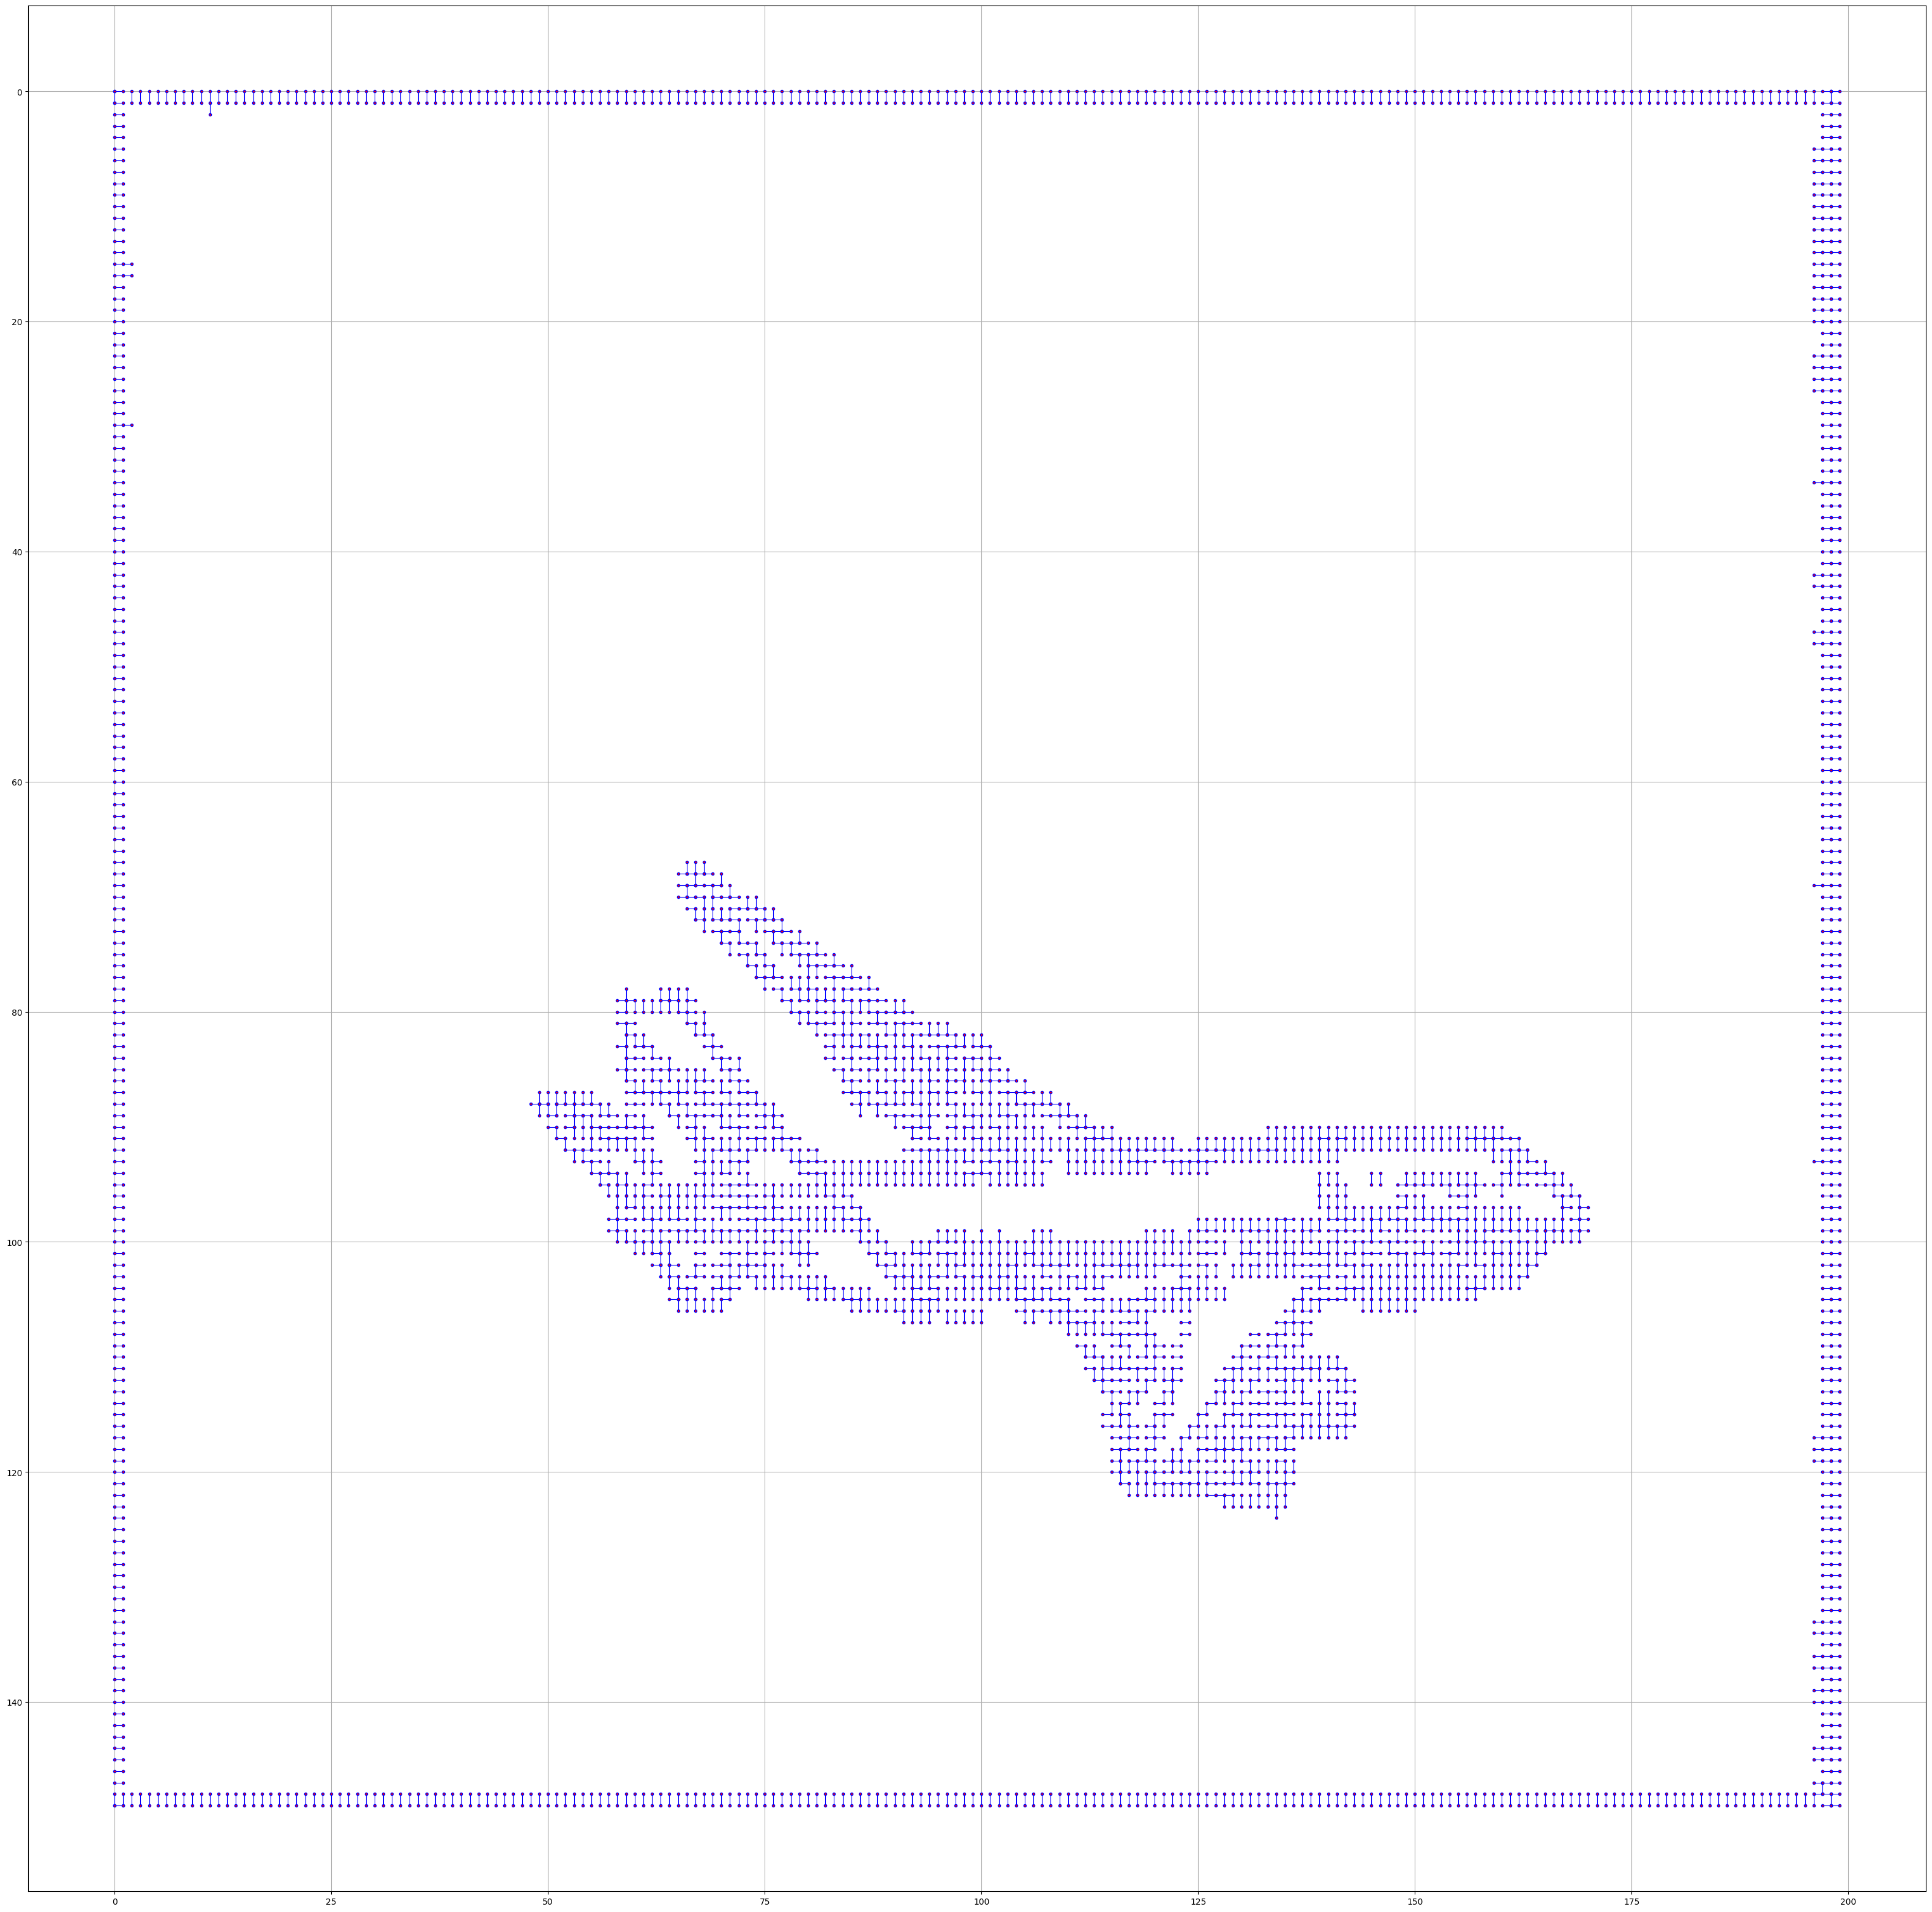

In [16]:
plot_csr(minimum_graph)

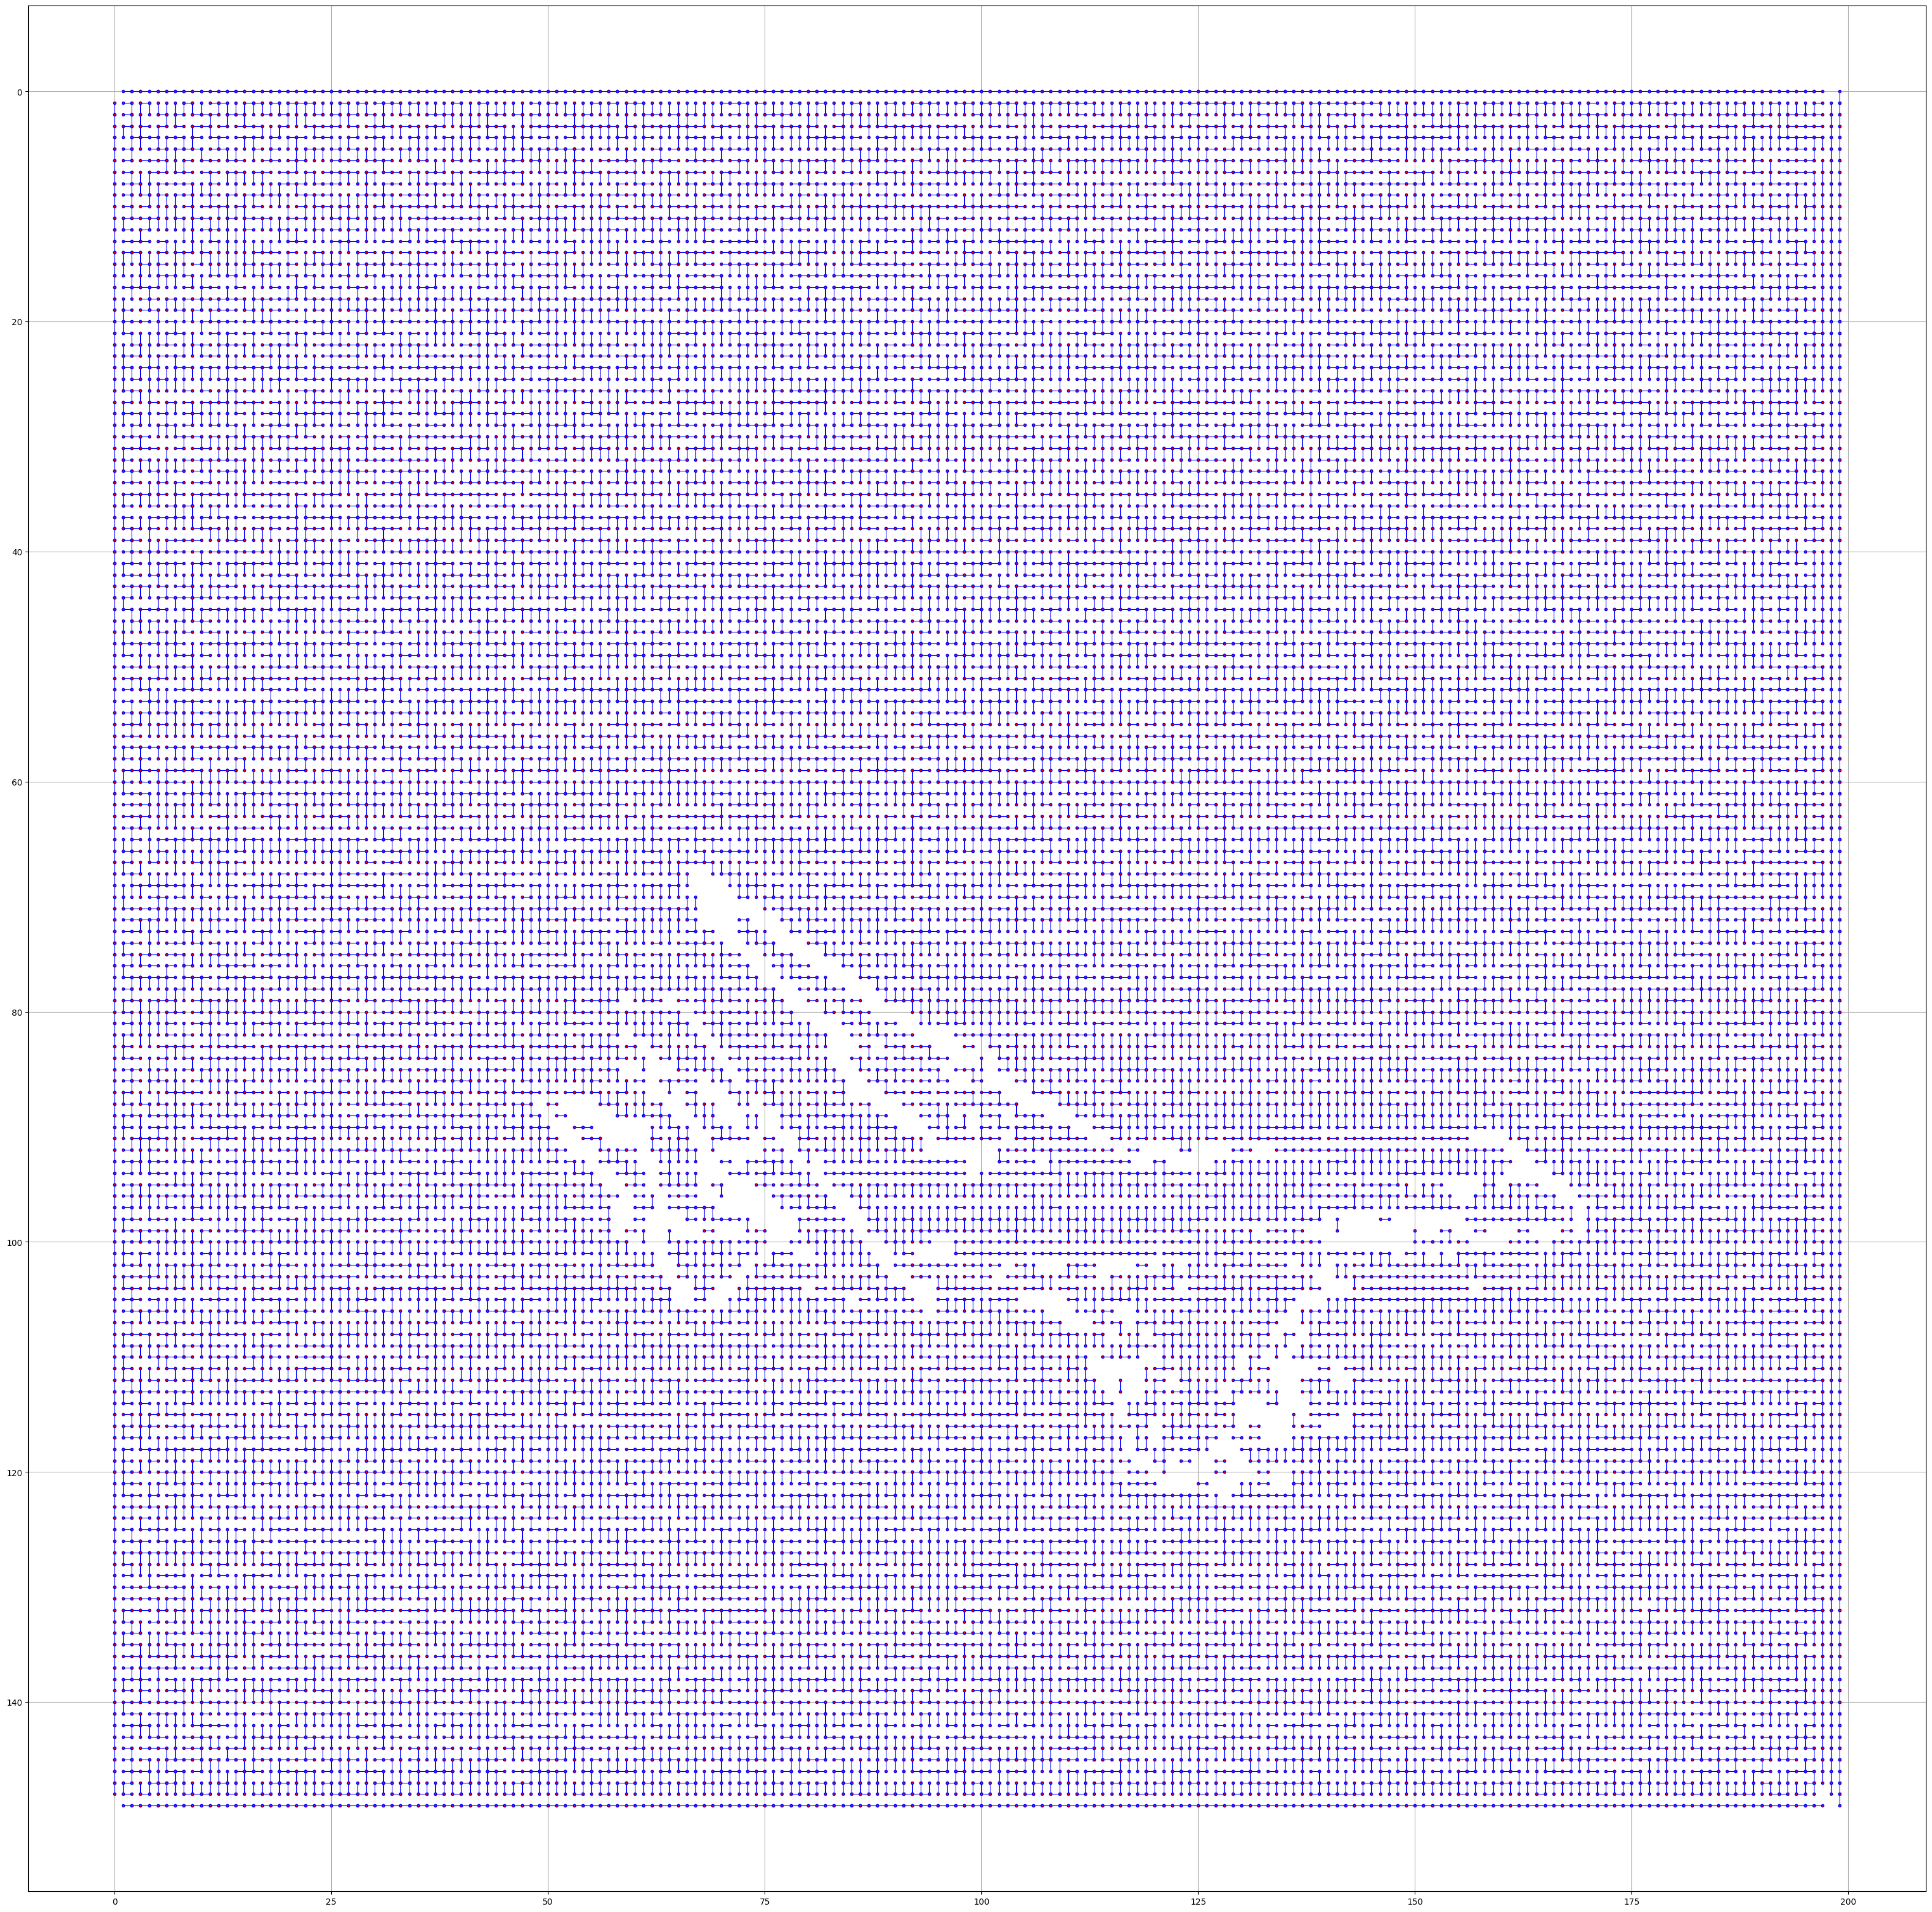

In [17]:
plot_csr(maximum_graph)

In [18]:
difference_csr = maximum_graph - minimum_graph

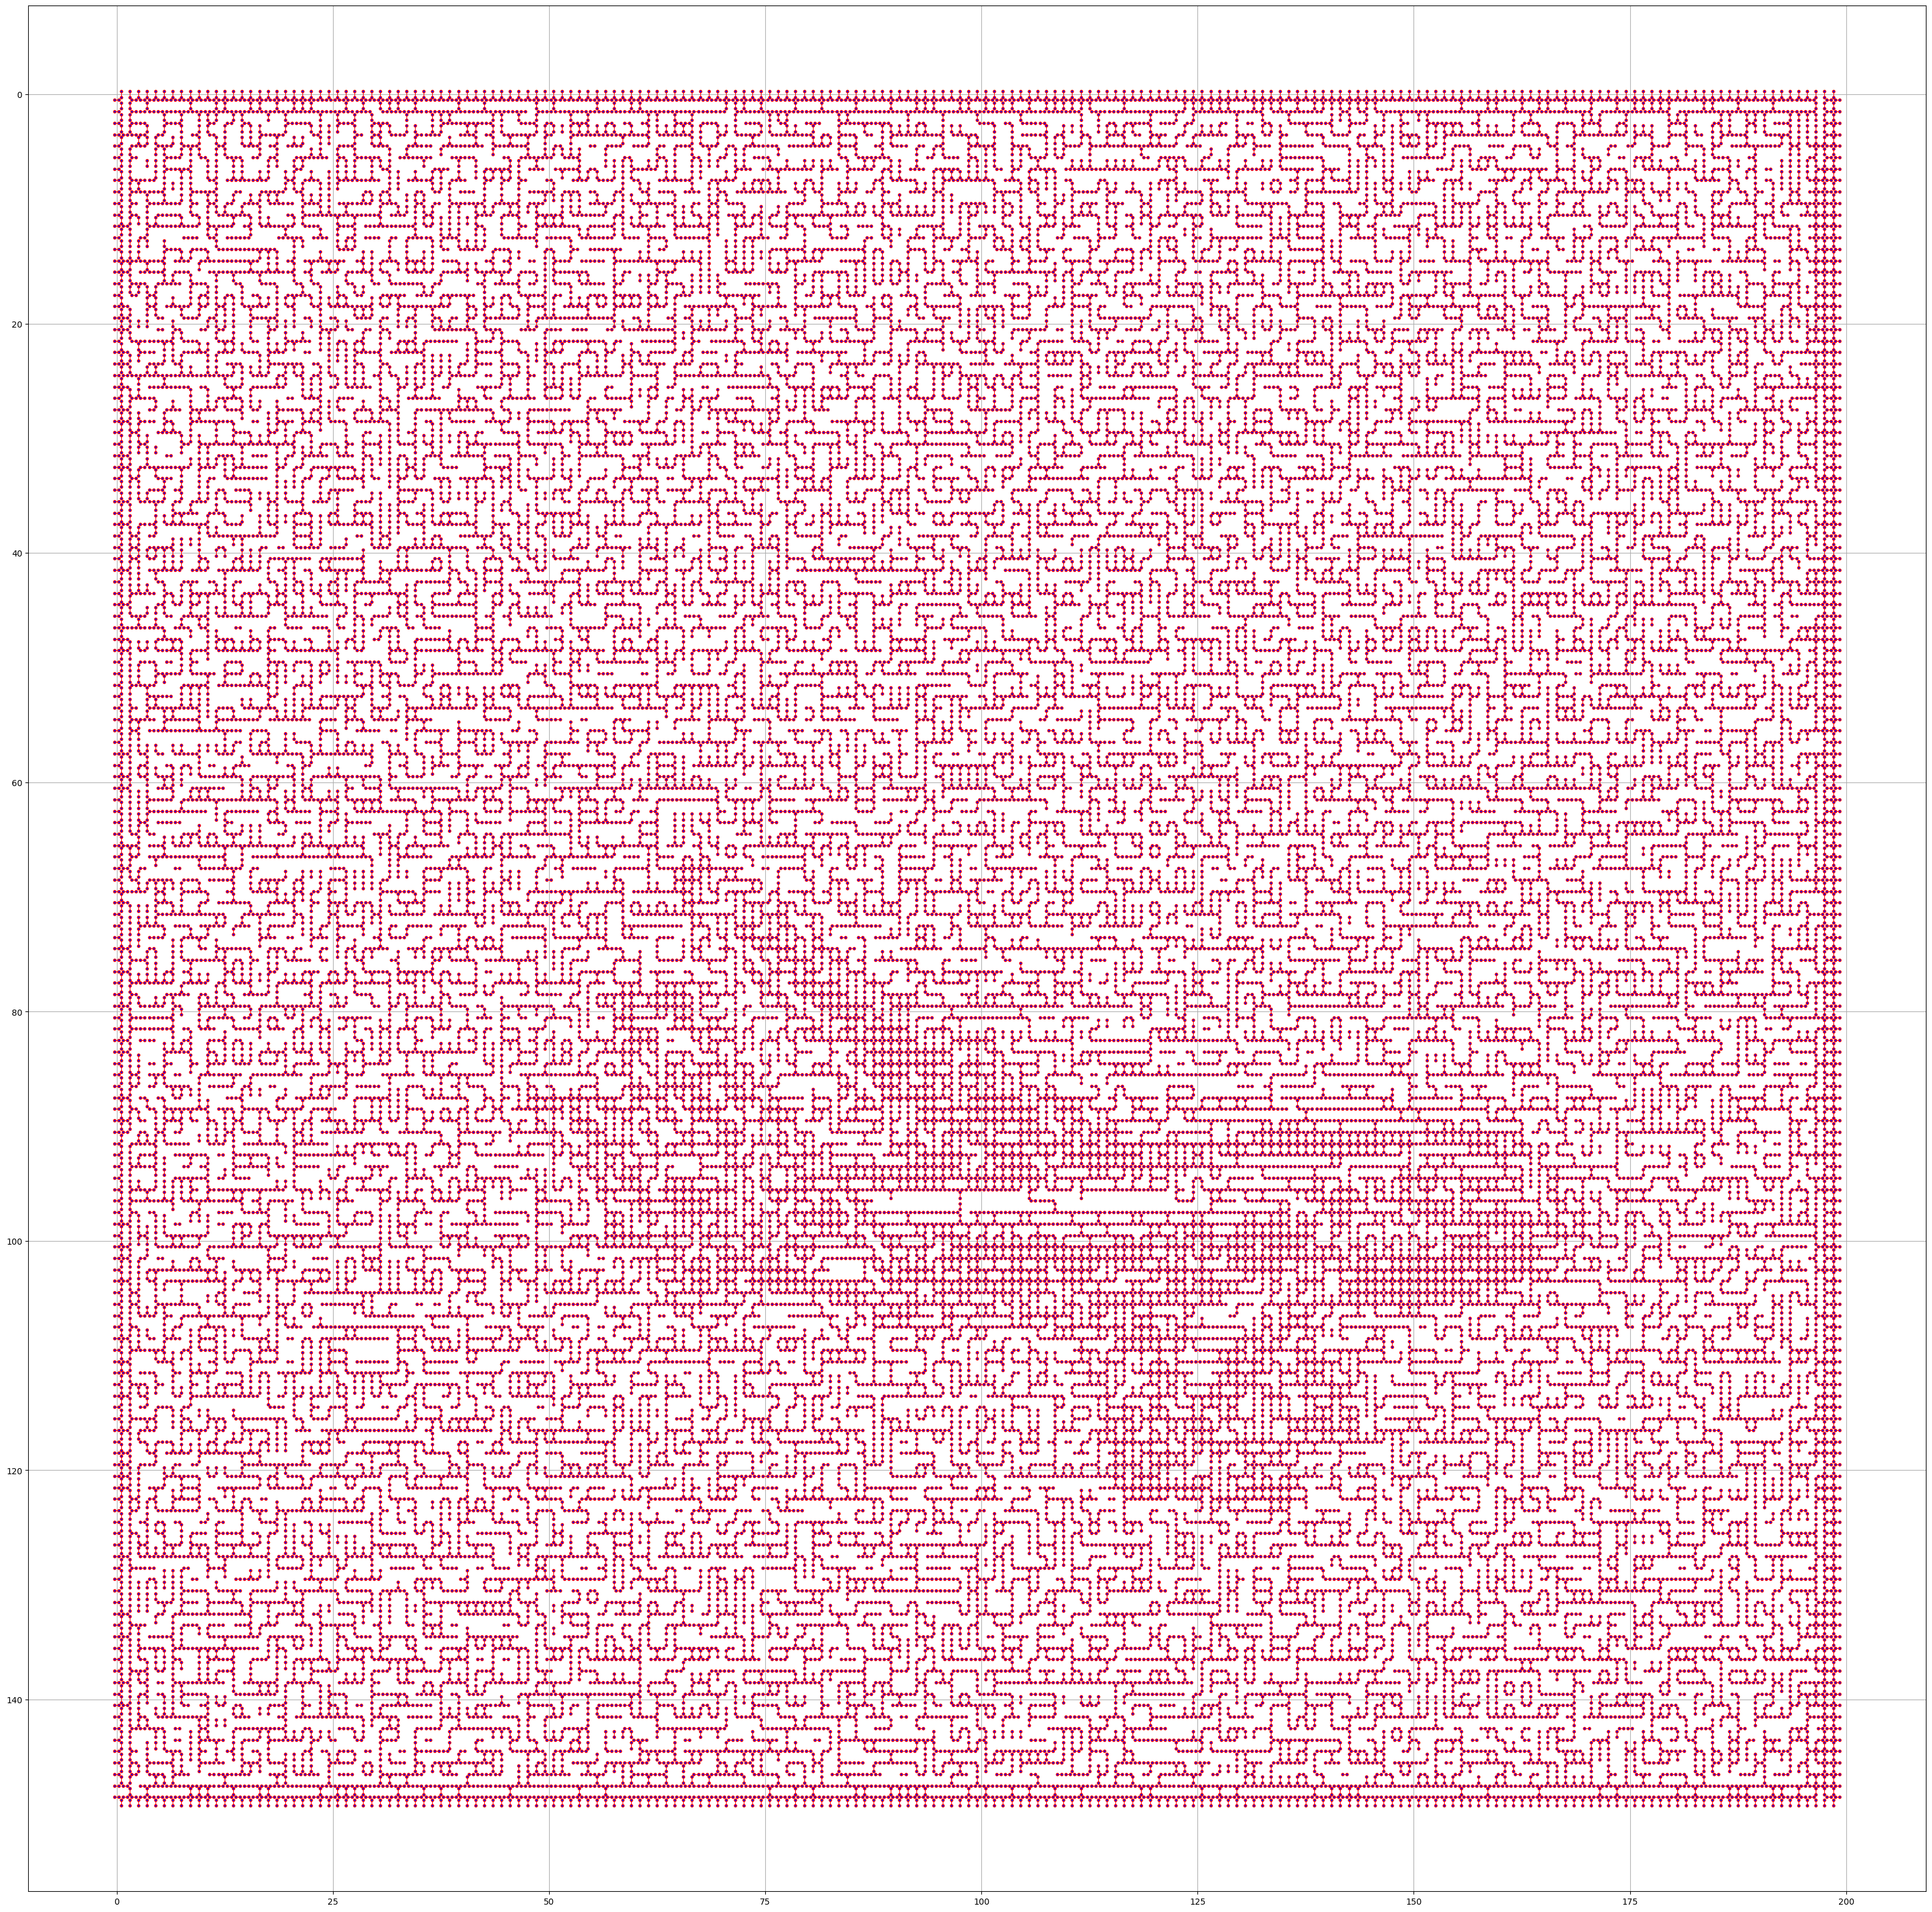

In [19]:
plot_csr(difference_csr, True, True)

In [20]:
def csgraph_to_img(graph, dimensions, pixel_value = 255, pix_range=0, rgb=False):
    rows, cols = dimensions

    img_array = np.zeros(rows*cols)

    for idx, x in enumerate(graph.toarray()):

        non_zero = np.where(x!=0)[0]
        if len(non_zero) == 0:
            continue

        for ind, _ in enumerate(non_zero):
            img_array[idx] = pixel_value
            img_array[ind-pix_range:ind+pix_range] = pixel_value

    if rgb:
        img_array = [[x, x, x] for x in img_array]
        
    img_array = np.reshape(img_array, (rows, cols, 3))

    return img_array
        

In [21]:
minimum_image = csgraph_to_img(minimum_graph, grey_img.shape, 200, rgb=True)

In [22]:
combined_image = img - minimum_image

In [23]:
combined_image = np.clip(combined_image, 0, 25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


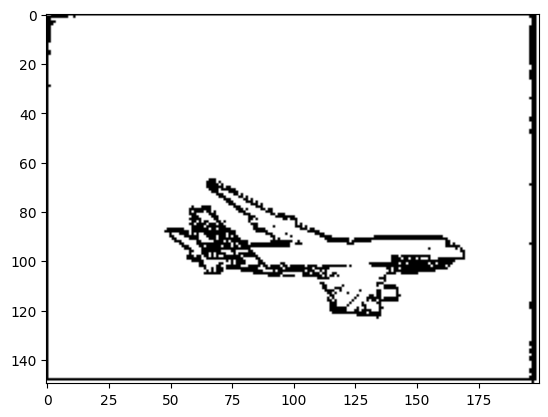

In [24]:
show_image(combined_image)